# <center><a>Генеративно-состязательные модели</a>
### <center><a>Реализация обучения</a>

<img src="img/gan.jpeg" width=400>

### <a>Содержание</a>
- [GAN](#1)
- [Wasserstein GAN](#2)
    - WGAN с клиппингом весов
    - WGAN со штрафом градиентов
- [Conditional GAN](#3)

___
## <center><a id=1>[GAN](https://arxiv.org/pdf/1406.2661)</a>
___

* Модифицируйте код ячеек ниже и реализуйте [Wasserstein GAN](https://arxiv.org/abs/1701.07875) с клиппингом весов. (10 баллов)

* Замените клиппинг весов на [штраф градентов](https://arxiv.org/pdf/1704.00028v3.pdf). (10 баллов)

* Добавьте лейблы в WGAN, тем самым решая задачу [условной генерации](https://arxiv.org/pdf/1411.1784.pdf). (30 баллов)

Добавьте в этот файл анализ полученных результатов с различными графиками обучения и визуализацию генерации. Сравните как работает клиппинг весов и штраф градиентов и попробуйте пронаблюдать какие недостатки имеет модель GAN.

In [1]:
from IPython import display
from tqdm import trange
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

import torchvision
import matplotlib.pyplot as plt
import numpy as np

from torch.autograd import Variable

### Простой конфиг (для хранения параметров, можете использовать и модифицировать)

In [2]:
class Config:
    pass

config = Config()
config.mnist_path = None
config.batch_size = 32
config.num_workers = 3
config.num_epochs = 50
config.noise_size = 100
config.print_freq = 500
config.img_size = 28 * 28

### Создаем dataloader

In [3]:
train = torchvision.datasets.FashionMNIST("fashion_mnist", train=True, transform=torchvision.transforms.ToTensor(), download=True)

In [4]:
dataloader = DataLoader(train, batch_size=config.batch_size, shuffle=True)
len(dataloader)

1875

In [5]:
image, label = next(iter(dataloader))
image.size()

torch.Size([32, 1, 28, 28])

### Создаем модель GAN

In [10]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(config.noise_size, 200),
            nn.ReLU(inplace=True),
            nn.Linear(200, 28*28),
            nn.Sigmoid())

    def forward(self, x):
        return self.model(x)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(28*28, 200),
            nn.ReLU(inplace=True),
            nn.Linear(200, 50),
            nn.ReLU(inplace=True),
            nn.Linear(50, 1),
            nn.Sigmoid())
    def forward(self, x):
        return self.model(x)

In [11]:
generator = Generator()
discriminator = Discriminator()

### Оптимизатор и функция потерь

In [12]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

generator = generator.to(device)
discriminator = discriminator.to(device)

optim_G = optim.Adam(params=generator.parameters(), lr=0.0001)
optim_D = optim.Adam(params=discriminator.parameters(), lr=0.0001)

criterion = nn.BCELoss()

### Для оптимизации процесса обучения можно заранее определить переменные и заполнять их значения новыми данными

In [61]:
noise = torch.randn((config.batch_size, config.noise_size,), device=device, requires_grad=True)
label = Variable(torch.zeros((config.batch_size, ), device=device))
real_label = 1
fake_label = 0

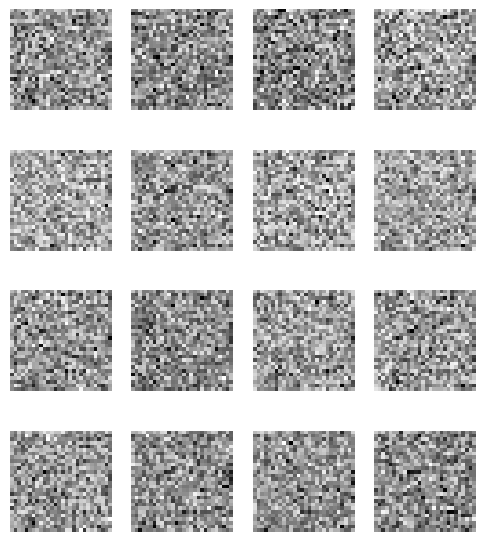

In [62]:
noise.data.normal_(0, 1)
fake = generator(noise)

plt.figure(figsize=(6, 7))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(fake[i].detach().cpu().numpy().reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.axis('off')

### График обучения

In [37]:
def plot_train(D_loss: torch.Tensor, G_loss: torch.Tensor) -> None: 
    
    plt.style.use('ggplot')
    display.clear_output(True)
    fig = plt.figure(figsize=(15, 10))
    
    plt.plot(D_loss, label=f"Discriminator loss: {D_loss[-1]:.3f}", alpha=0.5)
    plt.plot(G_loss, label=f"Generator loss: {G_loss[-1]:.3f}")

    plt.legend()
    plt.title("Discriminator and Generator Losses")
    plt.xlabel("Iterations")
    plt.ylabel("Loss value")
    plt.show()

### GAN обучение

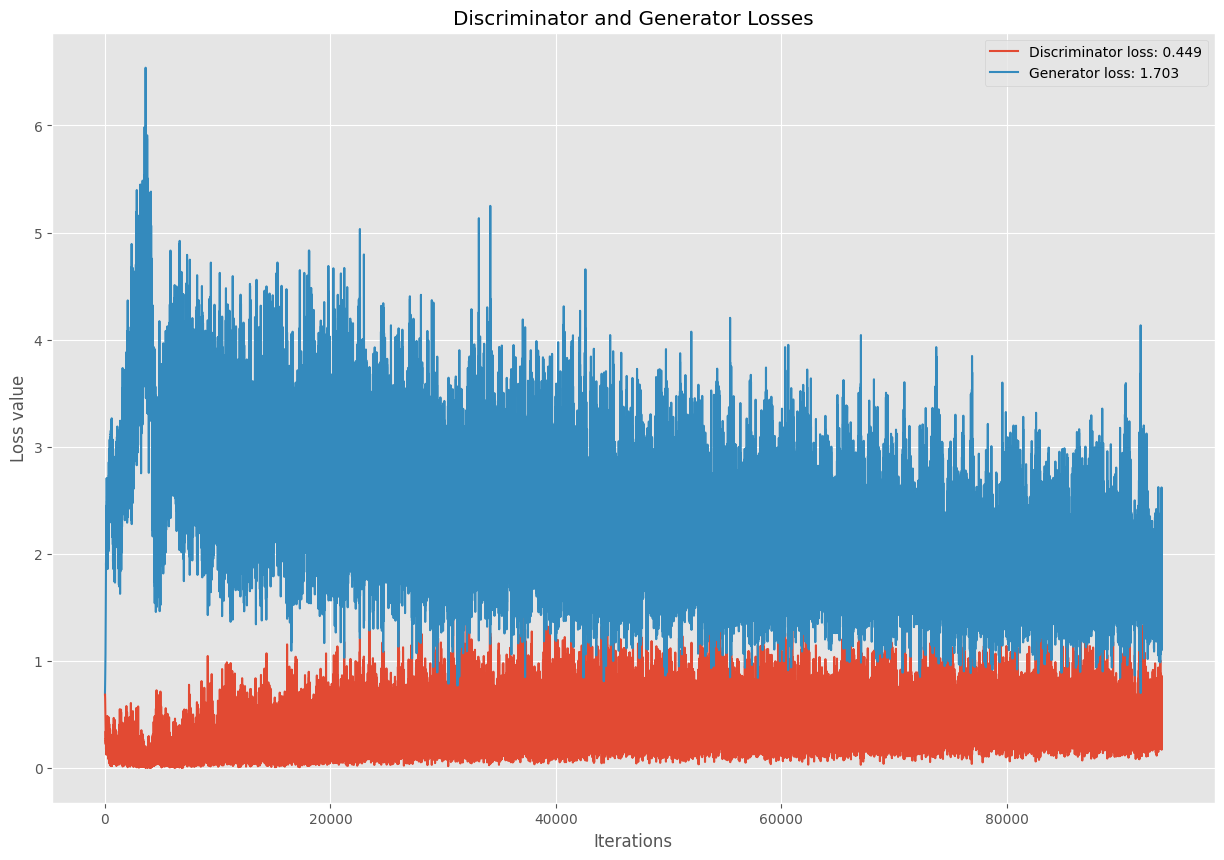

100%|██████████| 50/50 [11:02<00:00, 13.25s/it]


In [64]:
ERRD_x = []
ERRD_z = []
ERRG = []
N = len(dataloader)

for epoch in trange(config.num_epochs):
    for iteration, (images, cat) in enumerate(dataloader):
        #######
        # Discriminator stage: maximize log(D(x)) + log(1 - D(G(z)))
        #######
        discriminator.zero_grad()

        # real
        label.data.fill_(real_label)
        input_data = images.view(images.shape[0], -1).to(device)
        output = discriminator(input_data).view(-1)
        errD_x = criterion(output, label)
        ERRD_x.append(errD_x.item())
        errD_x.backward()

        # fake
        noise.data.normal_(0, 1)
        fake = generator(noise)
        label.data.fill_(fake_label)
        output = discriminator(fake.detach()).view(-1)
        errD_z = criterion(output, label)
        ERRD_z.append(errD_z.item()) 
        errD_z.backward()

        optim_D.step()

        #######
        # Generator stage: maximize log(D(G(x))
        #######
        generator.zero_grad()
        label.data.fill_(real_label)
        output = discriminator(fake).view(-1)
        errG = criterion(output, label)
        ERRG.append(errG.item()) 
        errG.backward()

        optim_G.step()
        
    plot_train(ERRD_x, ERRG)

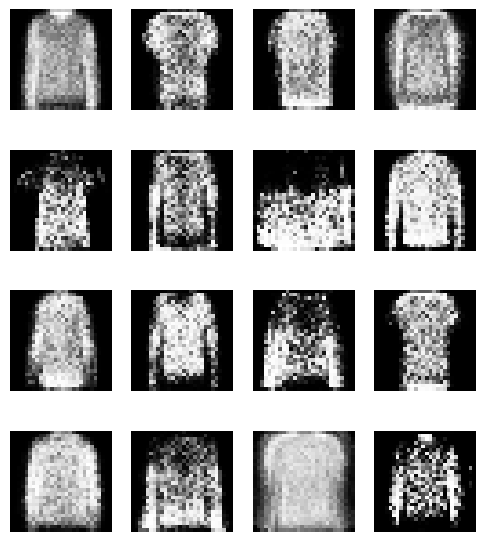

In [65]:
noise.data.normal_(0, 1)
fake = generator(noise)

plt.figure(figsize=(6, 7))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(fake[i].detach().cpu().numpy().reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.axis('off')

___
## <center><a id=2>[Wasserstein GAN](https://arxiv.org/abs/1701.07875)</a>
___

- ### $\boxed{\text{С клипингом весов}}$ 
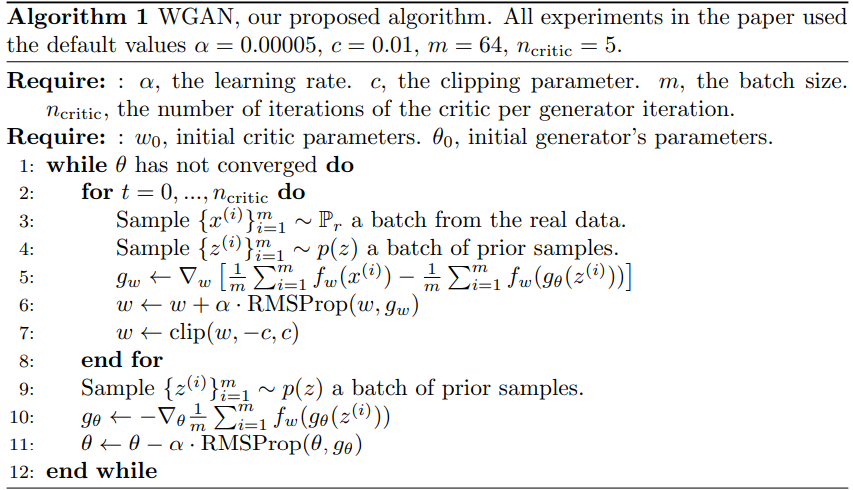

### Архитектура WGAN

In [431]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(config.noise_size, 200),
            nn.ReLU(inplace=True),
            nn.Linear(200, 28*28),
            nn.Sigmoid())

    def forward(self, x):
        return self.model(x)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(28*28, 200),
            nn.ReLU(inplace=True),
            nn.Linear(200, 50),
            nn.ReLU(inplace=True),
            nn.Linear(50, 1))
        
    def forward(self, x):
        return self.model(x)

### Инициализация переменных и моделей

In [433]:
LR = 5e-5
CLIP = 0.01
N_CRITIC = 5

generator = Generator().to(device)
discriminator = Discriminator().to(device)

### Генерация до обучения

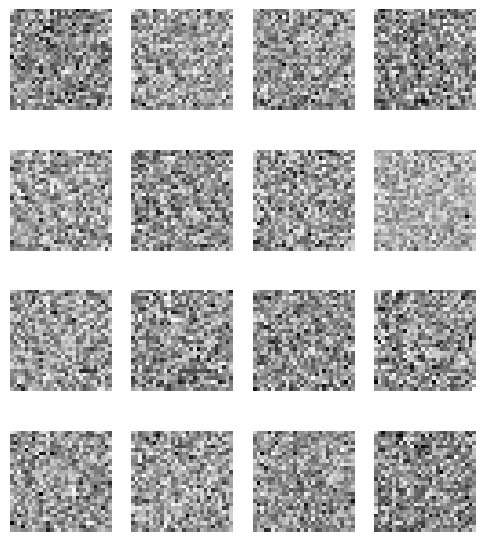

In [69]:
noise.data.normal_(0, 1)
fake = generator(noise)

plt.figure(figsize=(6, 7))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(fake[i].detach().cpu().numpy().reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.axis('off')

### Оптимизатор

In [70]:
optim_G = optim.RMSprop(params=generator.parameters(), lr=LR)
optim_D = optim.RMSprop(params=discriminator.parameters(), lr=LR)

### WGAN обучение с клиппингом весов

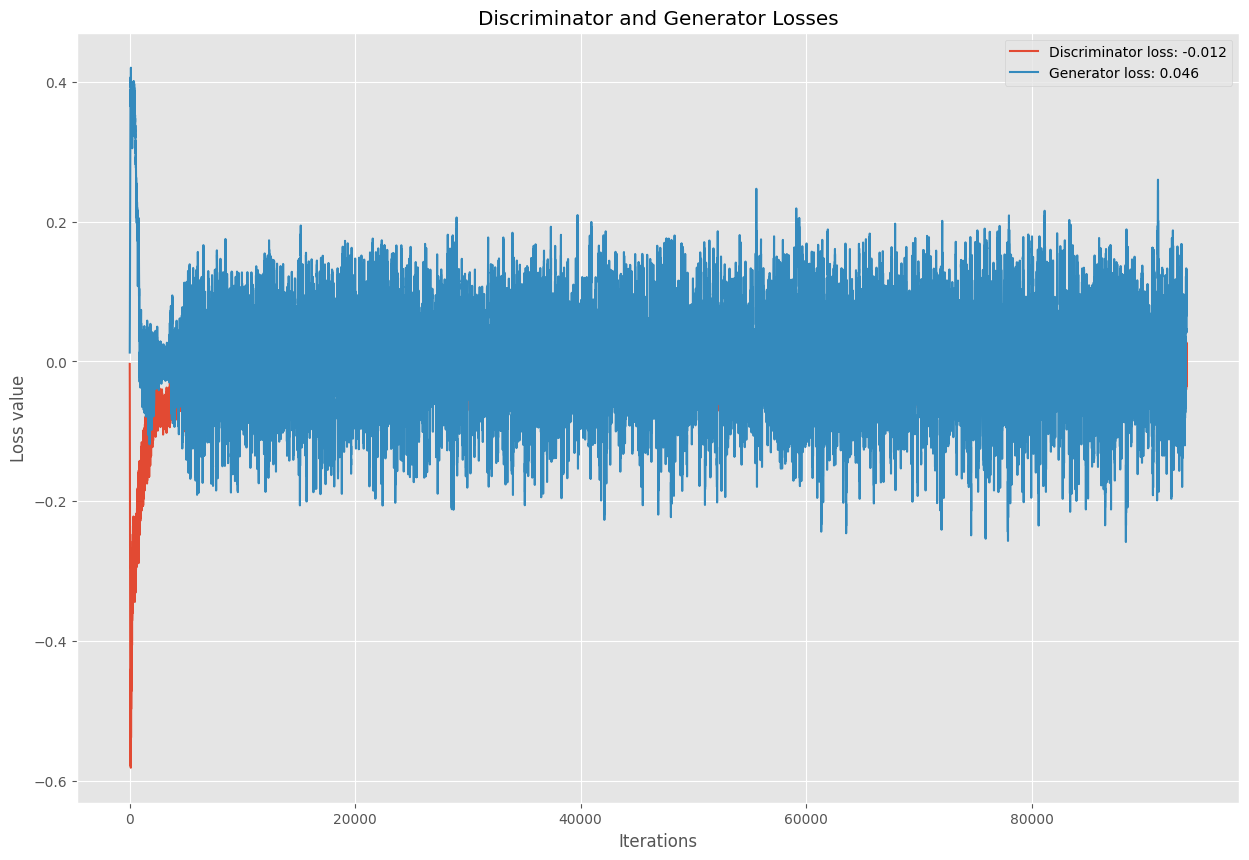

In [71]:
D_loss_all = []
G_loss_all = []
N = len(dataloader)

for epoch in range(config.num_epochs):
    for iteration, (images, cat) in enumerate(dataloader):
        for _ in range(N_CRITIC):
            #######
            # Discriminator stage
            #######
            discriminator.zero_grad()

            noise.data.normal_(0, 1)
            fake_data = generator(noise)
            real_data = images.view(images.shape[0], -1).to(device)
            
            output_fake_data = discriminator(fake_data.detach()).view(-1)
            output_real_data = discriminator(real_data).view(-1)
            
            D_loss = torch.mean(output_real_data) - torch.mean(output_fake_data)
            
            D_loss.backward()
            optim_D.step()

            # weights clipping
            for param in discriminator.parameters():
                param.data.clamp_(-CLIP, CLIP)
                
        D_loss_all.append(D_loss.item())
        #######
        # Generator stage
        #######
        generator.zero_grad()
        fake_data = generator(noise)
        
        G_loss = torch.mean(discriminator(fake_data))
        
        G_loss_all.append(G_loss.item()) 
        
        G_loss.backward()
        optim_G.step()

        if (iteration+1) % config.print_freq == 0:
            print('Epoch:{} Iter: {} D_loss: {:.2f} G_loss: {:.2f}'.format(epoch+1,
                                                                                iteration+1,
                                                                                D_loss.item(),
                                                                                G_loss.item()))
    plot_train(D_loss_all, G_loss_all)

### Генерация после обучения

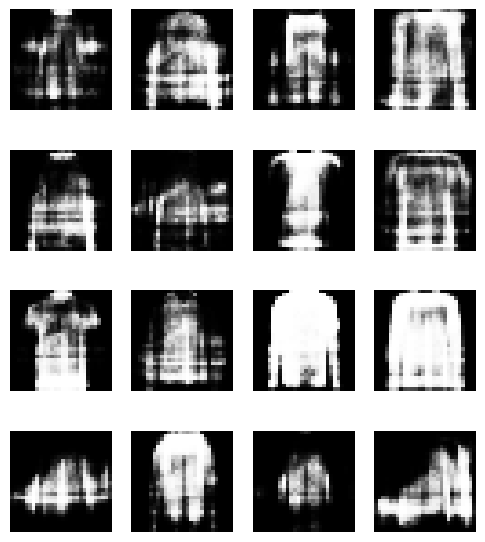

In [72]:
noise.data.normal_(0, 1)
fake = generator(noise)

plt.figure(figsize=(6, 7))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(fake[i].detach().cpu().numpy().reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.axis('off')

___
- ### $\boxed{\text{Со штрафом градиентов}}$ 
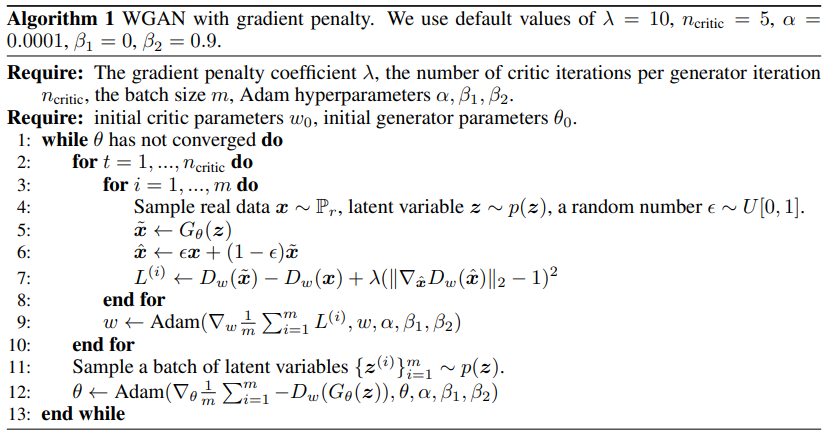

### Инициализация переменных и моделей

In [429]:
LAMBDA = 10
LR = 1e-4
BETA_1 = 0
BETA_2 = 0.9
N_CRITIC = 5
N_EPOCHS = 50

device = 'cuda' if torch.cuda.is_available() else 'cpu'
generator = Generator().to(device)
discriminator = Discriminator().to(device)

### Генерация до обучения

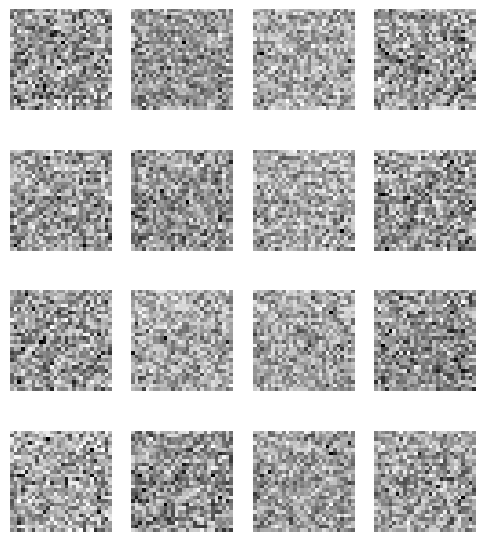

In [434]:
noise.data.normal_(0, 1)
fake = generator(noise)

plt.figure(figsize=(6, 7))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(fake[i].detach().cpu().numpy().reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.axis('off')

### Оптимизатор

In [81]:
optim_G = optim.Adam(params=generator.parameters(), lr=LR, betas=(BETA_1, BETA_2))
optim_D = optim.Adam(params=discriminator.parameters(), lr=LR, betas=(BETA_1, BETA_2))

### Штраф градиентов

In [82]:
def grad_penalty(discriminator: nn.Module, real_data: torch.Tensor, fake_data: torch.Tensor) -> torch.Tensor:
    eta = torch.rand(real_data.size(0), 1).to(device)
    inter_data = eta * real_data + (1 - eta) * fake_data

    output_inter_data = discriminator(inter_data)
    grads = torch.autograd.grad(outputs=output_inter_data,
                                inputs=inter_data,
                                grad_outputs=torch.ones(output_inter_data.size()).to(device),
                                create_graph=True,
                                retain_graph=True)[0]

    penalty = ((torch.norm(grads, p=2, dim=1) - 1)**2).mean()
    
    return penalty

grad_penalty(discriminator, real_data, fake_data)

tensor(0.7912, device='cuda:0', grad_fn=<MeanBackward0>)

### WGAN обучение со штрафом градиентов

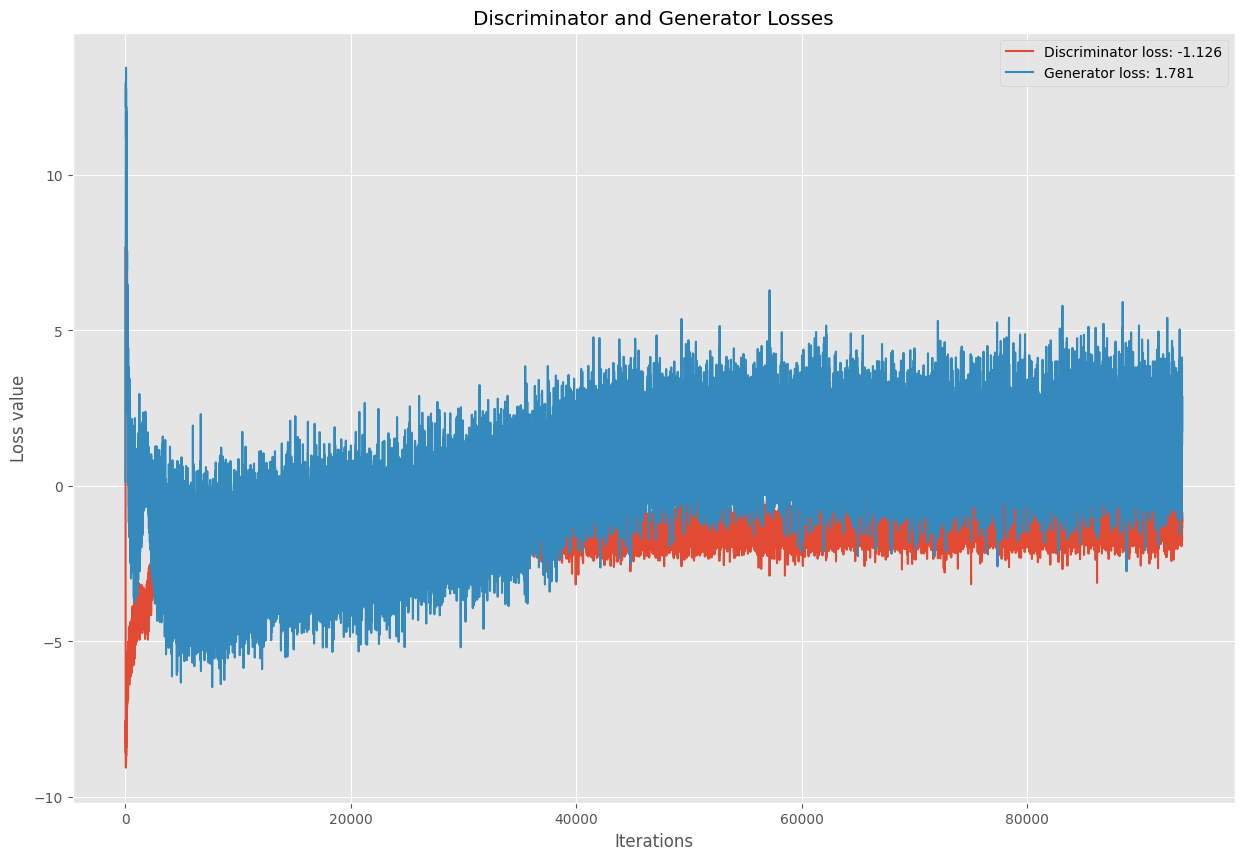

In [83]:
D_loss_all = []
G_loss_all = []
N = len(dataloader)

for epoch in range(N_EPOCHS):
    for iteration, (images, cat) in enumerate(dataloader):
        for _ in range(N_CRITIC):
            #######
            # Discriminator stage
            #######
            discriminator.zero_grad()

            noise.data.normal_(0, 1)
            fake_data = generator(noise)
            real_data = images.view(images.shape[0], -1).to(device)
            
            output_fake_data = discriminator(fake_data.detach()).view(-1)
            output_real_data = discriminator(real_data).view(-1)
            
            D_loss = torch.mean(output_real_data) - torch.mean(output_fake_data) + LAMBDA * grad_penalty(discriminator,
                                                                                                        real_data,
                                                                                                        fake_data)
            
            D_loss.backward()
            optim_D.step()
        D_loss_all.append(D_loss.item())
        #######
        # Generator stage
        #######
        generator.zero_grad()
        fake_data = generator(noise)
        
        G_loss = torch.mean(discriminator(fake_data))
        
        G_loss_all.append(G_loss.item()) 
        G_loss.backward()
        optim_G.step()

        if (iteration+1) % config.print_freq == 0:
            print('Epoch:{} Iter: {} D_loss: {:.2f} G_loss: {:.2f}'.format(epoch+1,
                                                                            iteration+1,
                                                                            D_loss.item(),
                                                                            G_loss.item()))
    plot_train(D_loss_all, G_loss_all)

### Генерация после обучения

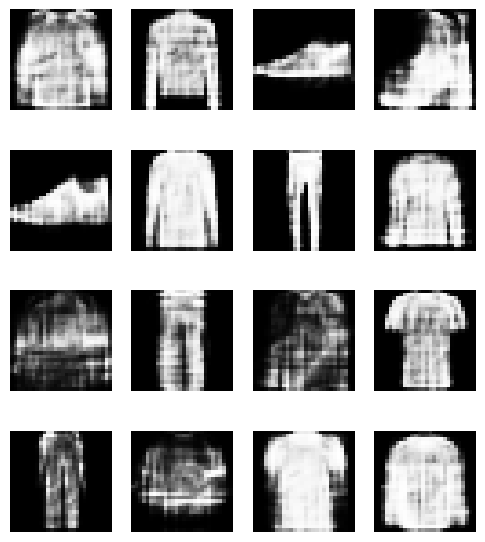

In [84]:
noise.data.normal_(0, 1)
fake = generator(noise)

plt.figure(figsize=(6, 7))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(fake[i].detach().cpu().numpy().reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.axis('off')

___
___
### Выводы:
- Основные нововведения в `WGAN`:
    - В качестве функции потерь используется расстояние Вассерштейна.
    - Выходные данные дискриминатора не ограничиваются диапазоном [0, 1].
    - Осуществляется ограничение весов в пределах [-0.01, 0.01] / Добавляется штраф на градиенты.
    - Дискриминатор проходит дополнительные итерации обучения перед вычислением функции потерь для генератора.
    - В WGAN с использованием штрафов на градиенты скорость вычислений снижается из-за дополнительных расчетов, связанных с этими штрафами.

- Как видно из графиков, `WGAN` демонстрирует более стабильное обучение и высокую скорость сходимости.
- Качество генерации WGAN значительно выше GAN

___
## <center><a id=3>[Conditional GAN](https://arxiv.org/pdf/1411.1784.pdf)</a>
___

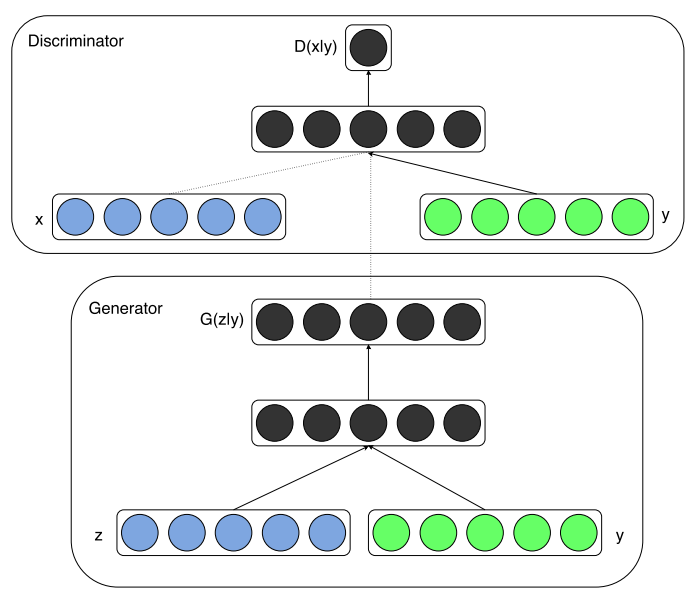
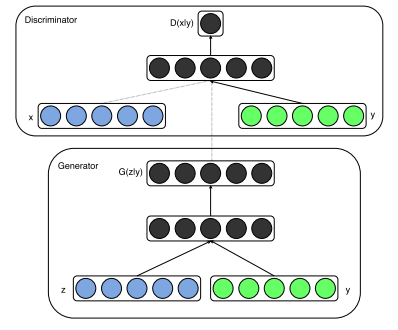

### Инициализация переменных

In [473]:
N_CLASSES = 10
LAMBDA = 10
LR = 1e-4
BETA_1 = 0
BETA_2 = 0.9
N_CRITIC = 5
N_EPOCHS = 50

target_dict = {
    0:'футболка',
    1:'брюки',
    2:'свитер',
    3:'платье',
    4:'пальто',
    5:'сандалия',
    6:'рубашка',
    7:'кроссовок',
    8:'сумка',
    9:'сапог',
            }

### Архитектура Conditional WGAN

In [474]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(config.noise_size + N_CLASSES, 200),
            nn.ReLU(inplace=True),
            nn.Linear(200, config.img_size),
            nn.Sigmoid())

    def forward(self, x):
        
        return self.model(x)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(config.img_size + + N_CLASSES, 200),
            nn.ReLU(inplace=True),
            nn.Linear(200, 50),
            nn.ReLU(inplace=True),
            nn.Linear(50, 1))
        
    def forward(self, x):
        return self.model(x)

generator = Generator().to(device)
discriminator = Discriminator().to(device)

### Оптимизатор

In [475]:
optim_G = optim.Adam(params=generator.parameters(), lr=LR, betas=(BETA_1, BETA_2))
optim_D = optim.Adam(params=discriminator.parameters(), lr=LR, betas=(BETA_1, BETA_2))

### Визуализация генерации

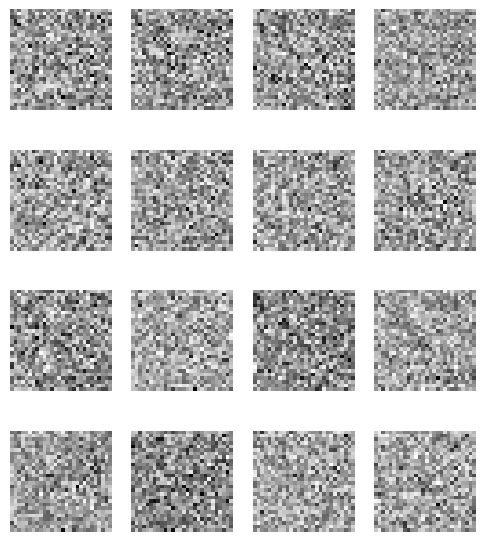

In [476]:
def plot_generation(generator: torch.nn.Module, noise: torch.Tensor, labels: int=None) -> None:
    generator.eval()
    noise.data.normal_(0, 1)

    if labels is not None:
        noise = torch.cat((noise, labels.to(device)), dim=1)
    fake = generator(noise)

    display.clear_output(True)
    f = plt.figure(figsize=(6, 7))
    for i in range(16):
        plt.subplot(4, 4, i + 1)
        plt.imshow(fake[i].detach().cpu().numpy().reshape(28, 28), cmap=plt.cm.Greys_r)
        plt.axis('off')
    plt.show()


noise = torch.randn((config.batch_size, config.noise_size,), device=device, requires_grad=True)
rand_labels = torch.randint(1, 10, size=(1, 32))
labels_ohe = torch.eye(10)[rand_labels].squeeze(0)
plot_generation(generator=generator, noise=noise, labels=labels_ohe)

### Визуализация генерации и функции потерь при обучении

In [477]:
def plot_train_gen(generator: torch.nn.Module,
                    noise: torch.Tensor,
                    D_loss: torch.Tensor,
                    G_loss: torch.Tensor,
                    label_dict: dict,
                    labels: int=None) -> None:

    generator.eval()
    noise.data.normal_(0, 1)
    
    if labels is not None:
        noise_cat = torch.cat((noise, labels.to(device)), dim=1)
    else:
        noise_cat = noise
    fake = generator(noise_cat)
    
    display.clear_output(True)
    f, ax = plt.subplots(1, 2, figsize=(20, 10))
    
    rand_class = np.random.randint(0, N_CLASSES)
    current_class = fake[rand_class][-10:].argmax().item()
    ax[0].imshow(fake[rand_class].detach().cpu().numpy().reshape(28, 28), cmap=plt.cm.Greys_r)
    ax[0].grid(False)
    ax[0].set_title("Current Generator fake image")
    ax[0].set_xlabel(f"{label_dict[current_class]}")
    
    ax[1].plot(D_loss, label=f"Discriminator loss: {D_loss[-1]:.3f}")
    ax[1].plot(G_loss, label=f"Generator loss: {G_loss[-1]:.3f}")
    ax[1].legend()
    ax[1].set_title("Discriminator and Generator Losses")
    ax[1].set_xlabel("Iterations")
    ax[1].set_ylabel("Loss value")
    plt.show()

### Штраф градиентов

In [478]:
def grad_penalty(discriminator: nn.Module, real_data: torch.Tensor, fake_data: torch.Tensor, label: torch.Tensor) -> torch.Tensor:
    eta = torch.rand(real_data.size(0), 1).to(device)
    inter_data = eta * real_data + (1 - eta) * fake_data
    
    inter_data_cat = torch.cat((inter_data, torch.eye(10)[cat].to(device)), dim=1)

    output_inter_data = discriminator(inter_data_cat)
    grads = torch.autograd.grad(outputs=output_inter_data,
                                inputs=inter_data,
                                grad_outputs=torch.ones(output_inter_data.size()).to(device),
                                create_graph=True,
                                retain_graph=True)[0]

    penalty = ((torch.norm(grads, p=2, dim=1) - 1)**2).mean()
    
    return penalty

# grad_penalty(discriminator, real_data, fake_data, cat)

### Conditional GAN обучение со штрафом градиентов

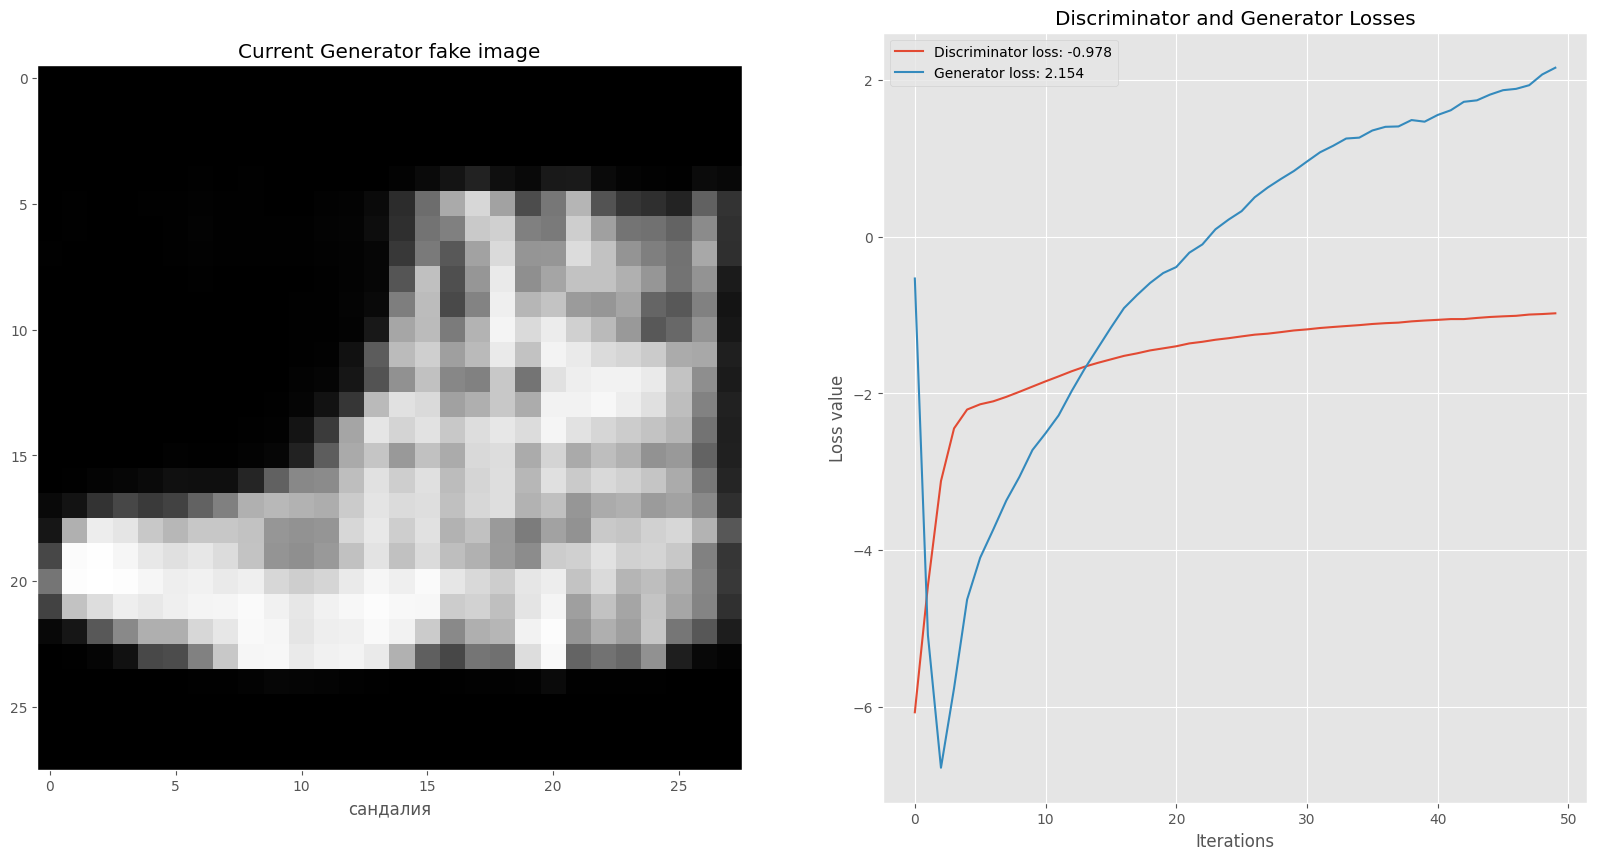

In [479]:
D_loss_all = []
G_loss_all = []
D_loss_plot = []
G_loss_plot = []
N = len(dataloader)

for epoch in range(N_EPOCHS):
    for iteration, (images, cat) in enumerate(dataloader):
        for _ in range(N_CRITIC):
            #######
            # Discriminator stage
            #######
            discriminator.zero_grad()

            cat_ohe = torch.eye(10)[cat].to(device)
            noise.data.normal_(0, 1)
            real_data = images.view(images.shape[0], -1).to(device)
            noise_cat = torch.cat((noise, cat_ohe), dim=1)
            images_cat = torch.cat((real_data, cat_ohe), dim=1)
            
            fake_data = generator(noise_cat)
            fake_data_cat = torch.cat((fake_data, cat_ohe), dim=1)
            output_fake_data = discriminator(fake_data_cat.detach()).view(-1)
            output_real_data = discriminator(images_cat).view(-1)
            
            D_loss = torch.mean(output_real_data) - torch.mean(output_fake_data) + LAMBDA * grad_penalty(discriminator,
                                                                                                        real_data,
                                                                                                        fake_data,
                                                                                                        cat)
            
            D_loss.backward()
            optim_D.step()
        D_loss_all.append(D_loss.item())
        #######
        # Generator stage
        #######
        generator.zero_grad()
        fake_data = generator(noise_cat)
        fake_data_cat = torch.cat((fake_data, cat_ohe), dim=1)
        G_loss = torch.mean(discriminator(fake_data_cat))
        
        G_loss_all.append(G_loss.item()) 
        G_loss.backward()
        optim_G.step()

        if (iteration+1) % config.print_freq == 0:
            print('Epoch:{} Iter: {} D_loss: {:.2f} G_loss: {:.2f}'.format(epoch+1,
                                                                            iteration+1,
                                                                            D_loss.item(),
                                                                            G_loss.item()))
    D_loss_plot.append(np.array(D_loss_all)[-int(60000 / config.batch_size):].mean())
    G_loss_plot.append(np.array(G_loss_all)[-int(60000 / config.batch_size):].mean())
    plot_train_gen(generator=generator,
                    noise=noise,
                    D_loss=D_loss_plot,
                    G_loss=G_loss_plot,
                    label_dict=target_dict,
                    labels=cat_ohe)
        


### Генерация заданных объектов после обучения

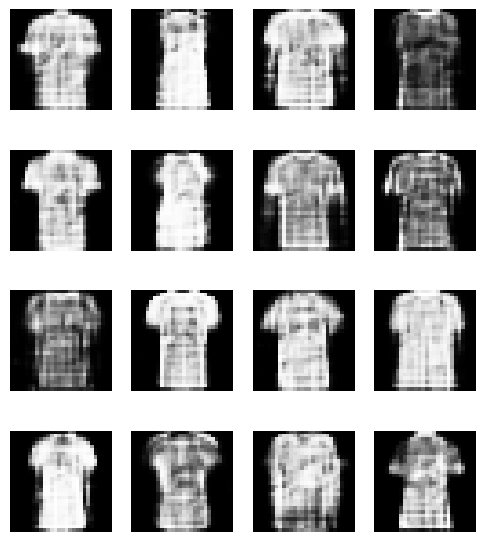

Generated label: футболка


In [494]:
label2gen = 0

noise = torch.randn((config.batch_size, config.noise_size,), device=device, requires_grad=True)
labels = torch.ones(size=(1, 32), dtype=torch.long) * label2gen
labels_ohe = torch.eye(10)[labels].squeeze(0)

plot_generation(generator=generator, noise=noise, labels=labels_ohe)
print(f"Generated label: {target_dict[label2gen]}")

___
___
### Выводы:
- Основные нововведения в `CGAN`:
    - Вход генератора и дискриминатора конкатенируется с метками класса, что дает возможность генерировать объекты заданного класса
    - Повышено разнообразие генерации объектов
    - Уменьшен риск коллапса моды распределения, т.к. генератор фокусируется на различных подмножествах данных
___